### SetUp  

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

In [ ]:
# GitHub 저장소 클론
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

In [ ]:
!pip install -q supervision jupyter_bbox_widget
!pip install ultralytics

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
# yolo11s best model
!gdown 1A6_iThtWBlzgvGqOP9QXuDYGFL809jYL

# test image
!gdown 1O6V2iz-T3T6YqlmMjPpTXT0RFEdtchNc # test01
!gdown 1JZA7_aM-k5-0N0kvvFLPcRI3RvRXo9zN # test02
!gdown 1VaDFbs3YPmwO5foQHbM4a32QMGDOYAZm # test03
!gdown 1uHkOEIMeeopf3AfhoCPfriXhLKkPNJBM # test04
!gdown 1JLNgO8GYuTZoAyJFHprDd1JZqC25Sq8M # test05
!gdown 1LTBmPwSoy6FVjhAS8ILFvaC7zUC4dFaI # test06

### Imports  

In [ ]:
import cv2
import torch
import base64

import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [8]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [9]:
# load model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

### (이미지) 세그멘테이션된 영역에 광고 이미지 삽입 로직  
**1. 객체 탐지 & 세그멘테이션**
  - 파인튜닝한 YOLO11s 모델과 SAM2 모델 이용
  - sam2_hiera_large.pt 이용  

**2. SAM2 세그멘테이션을 이용하여 정면 길이(평면 크기) 계산**  
  - 세그멘테이션 마스크에서 모서리 추출  

**3. 유클리드 거리 계산**  
  - np.linalg.norm() 사용  

**4. 원근 변환(Perspective Transform) 적용**  
  - 기울어진 광고판을 정면에서 본 것처럼 변환하는 과정
  - 필요한 이유 : 광고판이 기울어져 있거나, 원근법에 의해 찌그러져 보일 때 광고판을 정면에서 본 것처럼 변환이 필요  

**5. 광고 이미지 삽입**  


In [15]:
def get_mask_from_yolo_and_sam2(image_rgb, yolo_model, sam2_predictor):

    # YOLO 객체 탐지
    results = yolo_model(image_rgb)

    if len(results[0].boxes) == 0:
        raise ValueError("YOLO로 탐지된 객체가 없습니다.")

    # 가장 신뢰도 높은 박스 선택
    best_idx = results[0].boxes.conf.argmax()
    boxes = results[0].boxes.xyxy[[best_idx]].cpu().numpy().reshape(-1, 4)
    x1, y1, x2, y2 = boxes[0].astype(int)

    # SAM2 세그멘테이션
    sam2_predictor.set_image(image_rgb)
    masks, scores, logits = sam2_predictor.predict(box=boxes, multimask_output=False)

    if masks is None or np.sum(masks) == 0:
        raise ValueError("SAM2에서 유효한 마스크를 생성하지 못했습니다.")

    # 마스크 후처리
    if masks.ndim == 3:
        masks = np.squeeze(masks, axis=0)
    filtered_mask = np.zeros_like(masks)
    filtered_mask[y1:y2, x1:x2] = masks[y1:y2, x1:x2]
    masks = filtered_mask
    masks = (masks * 255).astype(np.uint8)

    # 노이즈 제거
    kernel = np.ones((5, 5), np.uint8)
    masks = cv2.morphologyEx(masks, cv2.MORPH_CLOSE, kernel)
    masks = cv2.GaussianBlur(masks, (5, 5), 0)

    return masks


In [16]:
# 세그멘테이션 마스크에서 광고판 꼭짓점 좌표 추출

def get_billboard_corners_from_mask(masks):
    contours, _ = cv2.findContours(masks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            corners = approx.reshape(4, 2)
            break
    else:
        raise ValueError("광고판 꼭짓점 4개를 찾을 수 없습니다.")

    return corners


In [17]:
# 광고판의 정면 가로 세로 길이 계산 (유클리드 거리)

def calculate_billboard_size(corners):
    # 좌표 정렬 (좌상/우상/우하/좌하)
    corners = sorted(corners, key=lambda x: x[1])
    top_corners = sorted(corners[:2], key=lambda x: x[0])
    bottom_corners = sorted(corners[2:], key=lambda x: x[0])
    pts_src = np.array([top_corners[0], top_corners[1], bottom_corners[1], bottom_corners[0]], dtype=np.float32)

    # 가로 세로 길이 계산
    width_top = np.linalg.norm(pts_src[1] - pts_src[0])
    width_bottom = np.linalg.norm(pts_src[2] - pts_src[3])
    real_width = max(width_top, width_bottom)

    height_left = np.linalg.norm(pts_src[3] - pts_src[0])
    height_right = np.linalg.norm(pts_src[2] - pts_src[1])
    real_height = max(height_left, height_right)

    return pts_src, real_width, real_height


In [18]:
# 새 광고 이미지 삽입 (원근 변환 이용)

def insert_new_billboard(image_rgb, pts_src, new_ad_path, real_width, real_height):
    # 새 광고 이미지 로드 및 크기 조정
    new_ad_bgr = cv2.imread(new_ad_path)

    if new_ad_bgr is None:
        raise FileNotFoundError(f"새 광고 이미지를 찾을 수 없습니다: {new_ad_path}")

    new_ad_rgb = cv2.cvtColor(new_ad_bgr, cv2.COLOR_BGR2RGB)
    resized_ad = cv2.resize(new_ad_rgb, (int(real_width), int(real_height)))

    # 원근 변환
    pts_dst = np.array([[0, 0], [real_width, 0], [real_width, real_height], [0, real_height]], dtype=np.float32)
    M_inverse = cv2.getPerspectiveTransform(pts_dst, pts_src)
    warped_back = cv2.warpPerspective(resized_ad, M_inverse, (image_rgb.shape[1], image_rgb.shape[0]), flags=cv2.INTER_CUBIC)

    # 마스크 생성 및 삽입
    mask = cv2.warpPerspective(np.ones_like(resized_ad[:, :, 0]) * 255, M_inverse,(image_rgb.shape[1], image_rgb.shape[0]), flags=cv2.INTER_NEAREST)
    masked_indices = (mask > 0)
    image_rgb[masked_indices] = warped_back[masked_indices]

    return image_rgb


In [19]:
# 광고판 삽입된 결과 이미지 반환
def process_advertisement_insertion(image_path, new_ad_path, yolo_model, sam2_predictor):
    # 원본 이미지 로드 및 RGB 변환
    image_bgr = cv2.imread(image_path)

    if image_bgr is None:
        raise FileNotFoundError(f"원본 이미지를 찾을 수 없습니다: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 1. YOLO + SAM2로 마스크 추출
    masks = get_mask_from_yolo_and_sam2(image_rgb, yolo_model, sam2_predictor)

    # 2. 마스크에서 광고판 꼭짓점 추출
    pts_src = get_billboard_corners_from_mask(masks)

    # 3. 광고판 정면 크기 계산
    pts_src, real_width, real_height = calculate_billboard_size(pts_src)

    # 4. 새 광고 삽입
    result_image = insert_new_billboard(
        image_rgb, pts_src, new_ad_path, real_width, real_height
    )

    return result_image


0: 448x640 6 billboards, 67.3ms
Speed: 3.1ms preprocess, 67.3ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 billboards, 56.2ms
Speed: 6.2ms preprocess, 56.2ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


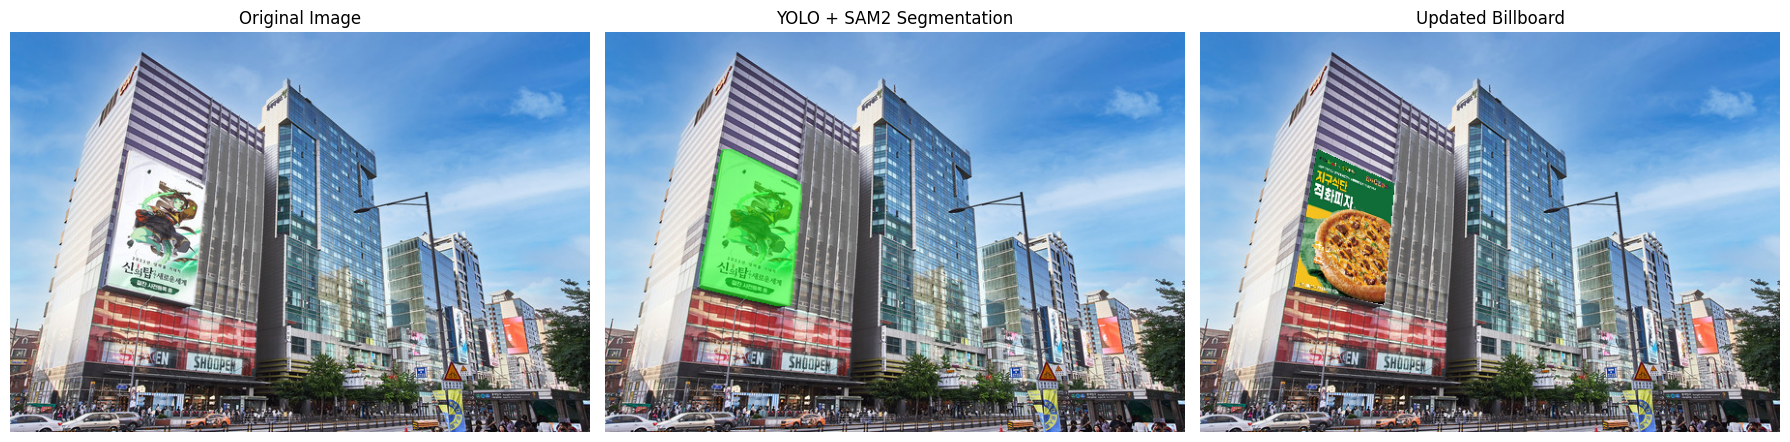

In [23]:
# 모델 로드
yolo_model = YOLO(f"{HOME}/segment-anything-2/best-0228.pt")
sam2_predictor = SAM2ImagePredictor(sam2_model)

# 이미지 경로
image_path = f"{HOME}/segment-anything-2/test06.jpg"
new_ad_path = "/content/new_ad_image.jpg"

# 광고판 삽입 처리
result_image = process_advertisement_insertion(image_path, new_ad_path, yolo_model, sam2_predictor)

# YOLO+SAM2로 세그멘테이션 마스크 추출
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
masks = get_mask_from_yolo_and_sam2(image_rgb, yolo_model, sam2_predictor)

# 세그멘테이션 마스크 오버레이
mask_overlay = image_rgb.copy()
mask_color = np.array([0, 255, 0], dtype=np.uint8)
alpha = 0.5  # 투명도 설정

# 마스크 영역에 색상 적용
mask_overlay[masks > 0] = (alpha * mask_color + (1 - alpha) * mask_overlay[masks > 0]).astype(np.uint8)


# 시각화 - 원본 / 세그멘테이션 오버레이 / 광고 교체된 결과 이미지
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask_overlay)
axes[1].set_title("YOLO + SAM2 Segmentation")
axes[1].axis("off")

axes[2].imshow(result_image)
axes[2].set_title("Updated Billboard")
axes[2].axis("off")

plt.tight_layout()
plt.show()